In [1]:
# Change the dataset in global_vars.py to KORA.
from global_vars import *
from func import *

import pickle as p
import glob 
import json
import subprocess
import getpass
import os
from nibabel.orientations import axcodes2ornt, ornt_transform, inv_ornt_aff, flip_axis
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

KORA_Extreme_Cases = {
    'skinniest': 'KORA2459692',
    'fattest': 'KORA2456507',
    'shortest': 'KORA2456230', 
    'tallest': 'KORA2459431'
}
vol_to_check_list =  ['KORA2458366']
exclude = []
one_time_n4_optimization = True

In [2]:
# ",".join(os.listdir('/home/abhijit/Jyotirmay/abdominal_segmentation/quickNAT_pytorch/create_datasets/datasets/lablmaps/KORA'))
data_dir

'/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti'

In [3]:
def load_kora_file_paths(load_from_txt_file=True):
    volumes_to_use = []
    if load_from_txt_file:
        with open(volume_txt_file) as file_handle:
                volumes_to_use = file_handle.read().splitlines()
    else:
        volumes_to_use = [name for name in os.listdir(data_dir)]
    
    file_paths = {}
    
    for vol in volumes_to_use:
        if (vol_to_check_list is not None and vol not in vol_to_check_list) or (vol == "") or (vol in exclude):
            continue
            
        labelmap_paths = glob.glob(f'{label_dir}/{vol}/**')
        opp_paths = glob.glob(f'{data_dir}/{vol}/**opp_[0-9]**.nii.gz')
        in_paths = glob.glob(f'{data_dir}/{vol}/**in_[0-9]**.nii.gz')
        f_paths = glob.glob(f'{data_dir}/{vol}/**F_[0-9]**.nii.gz')
        w_paths = glob.glob(f'{data_dir}/{vol}/**W_[0-9]**.nii.gz')
        
        vol_madals_paths = dict(
        OPP=opp_paths,
        IN=in_paths,
        F=f_paths,
        W=w_paths
        )
        file_paths[str(vol)]=dict(
            VOLUME_PATHS=vol_madals_paths,
            LABEL_PATHS=labelmap_paths,
        )
    return file_paths
        

In [4]:
file_paths = load_kora_file_paths()
file_paths

{'KORA2458366': {'VOLUME_PATHS': {'OPP': ['/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2458366/t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2458366/t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9.nii.gz'],
   'IN': ['/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2458366/t1_vibe_dixon_cor_caipi6_bh_288_iso_in_6.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2458366/t1_vibe_dixon_cor_caipi6_bh_288_iso_in_7.nii.gz'],
   'F': ['/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2458366/t1_vibe_dixon_cor_caipi6_bh_288_iso_F_1.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2458366/t1_vibe_dixon_cor_caipi6_bh_288_iso_F_2.nii.gz'],
   'W': ['/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2458366/t1_vibe_dixon_cor_caipi6_bh_288_iso_W_3.nii.gz',
    '/home/abhijit/nas_driv

In [5]:
# Individual RESCALING.
n4_dict = {}
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    print(f'n4 processing part-1 started with {vol}...')
    n4_dict[vol] = []
    vol_parts = [[file, read_ras(file)] for file in file_paths[vol]['VOLUME_PATHS']['IN']]
    for orig_file, in_image in vol_parts:
        n4_dict[vol].append(rescale(in_image, vol, orig_file))

In [6]:
# SITK does ot work due to differences in pixel resolution of IN and corresponding OPP Scan.
# Only applying once at the end.
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4-biasfield-correction starting with {vol}...')
    for idx, n4_d in enumerate(n4_dict[vol]):
        
        in_file = n4_d['SCALED']
        opp_file = file_paths[vol]['VOLUME_PATHS']['OPP'][idx]
        new_filename = opp_file.split('/')[-1].split('.')[0]
        output_file = f'{n4_corrected_data_dir}/vol/{vol}/{new_filename}_n4_corrected_sitk.nii.gz'
        SITK_N4_normalization(in_file, opp_file, output_file)
        n4_dict[vol][idx]['OPP_CORRECTED'] = output_file

    file_paths[vol]['N4_1'] = n4_dict[vol]

In [7]:
# # TODO: EXECUTE 'sudo sh ./n4-anne.sh' from command line for n4 bais field generation of all in imgs.

# for vol in file_paths.keys():
#     if one_time_n4_optimization:
#         break
#     print(f'applying n4 bias field on opp scans of {vol}...')
#     vol_parts = [[read_ras(opp_file), read_ras(n4_counterpart['IN_BIAS']), opp_file] for opp_file, n4_counterpart in zip(file_paths[vol]['VOLUME_PATHS']['OPP'],n4_dict[vol])]
#     idx = 0
#     file_paths[vol]['N4_1'] = []
#     for opp_img, bias_field_img, opp_file in vol_parts:
#         file_paths[vol]['N4_1'].append(apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol][idx], vol))
#         idx+=1
# #         n4_dict[vol].append(rescale(opp_image, vol, n4_dict[vol]))



In [8]:
# vol_to_check_list = None

In [9]:
# STITCHING VOL PARTS HERE
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'started with {vol}...')
    create_if_not(f'{n4_corrected_data_dir}/vol/{vol}')
    file_paths[vol]['ONE'] = {}
#     file_paths[vol]['ONE_ORIG'] = {}
    for modality_key in file_paths[vol]['VOLUME_PATHS'].keys():
        print(f"processing {modality_key}")
        orig_modal_key = modality_key
        if one_time_n4_optimization:
            vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]
        else:
            if modality_key == 'OPP':
                vol_parts = [read_ras(data_dict['OPP_CORRECTED']) for data_dict in file_paths[vol]['N4_1']]
                modality_key = modality_key+'_n4_corrected'
            else:
                vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]

        ras_stitched_resampled = multi_vol_stitching(vol_parts)
        save_volume(ras_stitched_resampled, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched')
#         save_volume(ras_stitched_orig, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched_orig')
        file_paths[vol]['ONE'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched.nii.gz'
#         file_paths[vol]['ONE_ORIG'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched_orig.nii.gz'

started with KORA2458366...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.         245.01789856]
 [  0.           0.          -1.69999695 144.90783691]
 [  0.          -1.70138884   0.          34.41421509]
 [  0.           0.           0.           1.        ]], Image Shape: (288, 288, 176)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[  -1.66666663    0.            0.          240.01789856]
 [   0.            0.           -1.69999695  144.90783691]
 [   0.           -1.66666663    0.         -200.58578491]
 [   0.            0.            0.            1.        ]], Image Shape: (288, 288, 176)
Transforming Images to RAS.....
0th img for stitching...
saving directory: temp/KORA/n4_corrected_2/vol/KORA2458366
processing IN
Reading Files.....
Reading Nifti Files.....
Affine:[[ -1.70138884   0.           0.         245.01789856]
 [  0.           0.          -1.69999695 144.90783691]
 [  0.        

In [10]:
# RESCALING INTENSITIES OF STITCHED VOLUME ABOVE 0
n4_dict = {}
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-2 started with {vol}...')
    n4_dict[vol] = {}
    in_stitched_file_path, in_stitched_img = file_paths[vol]['ONE']['IN'], read_ras(file_paths[vol]['ONE']['IN'])
    n4_dict[vol]['N4_2'] = rescale(in_stitched_img, vol, in_stitched_file_path)

n4 processing part-2 started with KORA2458366...
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -243.28070068]
 [   0.            2.            0.         -152.59162903]
 [   0.            0.            3.         -678.91912842]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)
Transforming Images to RAS.....
-91.68370819091797
neagtive value detected
saving directory: temp/KORA/n4_corrected_2/vol/KORA2458366


In [11]:
for vol in file_paths.keys():
#     if one_time_n4_optimization:
#         break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4-biasfield-correction starting with {vol}...')
    in_file = n4_dict[vol]['N4_2']['SCALED']
    print(in_file)
    opp_file = file_paths[vol]['ONE']['OPP']
    new_filename = opp_file.split('/')[-1].split('.')[0]
    output_file = f'{n4_corrected_data_dir}/vol/{vol}/{new_filename}_n4_corrected_sitk.nii.gz'
    SITK_N4_normalization(in_file, opp_file, output_file)
    n4_dict[vol]['N4_2']['OPP_CORRECTED'] = output_file
    file_paths[vol]['N4_2'] = n4_dict[vol]['N4_2']

n4-biasfield-correction starting with KORA2458366...
temp/KORA/n4_corrected_2/vol/KORA2458366/IN_ras_stitched_n4_scaled.nii.gz
done


In [12]:
# # TODO: EXECUTE 'sudo sh ./n4-anne-2.sh' from command line for n4 bais field generation of all in imgs.
# for vol in file_paths.keys():
#     if vol_to_check_list is not None and vol not in vol_to_check_list:
#         continue
#     print(f'applying n4 bias field on stitched opp scans of {vol}...')

#     opp_file = file_paths[vol]['ONE']['OPP']
#     n4_counterpart = n4_dict[vol]['N4_2']
#     print(opp_file, n4_counterpart['IN_BIAS'])
#     opp_img = read_ras(opp_file)
#     bias_field_img = read_ras(n4_counterpart['IN_BIAS'])

#     file_paths[vol]['N4_2'] = apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol]['N4_2'], vol)

In [13]:
with open('kora_file_paths.p', 'wb') as handle:
    p.dump(file_paths, handle, protocol=p.HIGHEST_PROTOCOL)

In [14]:
with open('kora_file_paths.p', 'rb') as handle:
    file_paths = p.load(handle)

In [15]:
print(json.dumps(file_paths, indent=4))

{
    "KORA2458366": {
        "VOLUME_PATHS": {
            "OPP": [
                "/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2458366/t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2458366/t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9.nii.gz"
            ],
            "IN": [
                "/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2458366/t1_vibe_dixon_cor_caipi6_bh_288_iso_in_6.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2458366/t1_vibe_dixon_cor_caipi6_bh_288_iso_in_7.nii.gz"
            ],
            "F": [
                "/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2458366/t1_vibe_dixon_cor_caipi6_bh_288_iso_F_1.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti/KORA2458366/t1_vibe_dixon_cor_caipi6_bh_288_iso_F_2.nii.gz"
      

In [16]:
def get_points_ext(label, vol):
    target_affine = vol.affine
    label_affine = label.affine
    labelmap2vol = npl.inv(target_affine).dot(label_affine)
    start_inv = np.floor(apply_affine(labelmap2vol, [0,0,0])).astype(np.int32)
    sx, sy,sz = start_inv
    end_inv = apply_affine(labelmap2vol, vol.shape).astype(np.int32)
    ex, ey, ez = end_inv
    return sx, sy,sz, ex, ey, ez

def visualize_overlay(file_paths):
    for vol_id in file_paths.keys():
        print(vol_id)
        vol = nb.load(f'{processed_dir}/volume/{vol_id}.nii.gz')
        label = nb.load(f'{processed_dir}/label/{vol_id}.nii.gz')
        im = vol.get_fdata()
        x = im.shape[0]//2
        masked = label.get_fdata()
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(im[x], 'gray', interpolation='none')
        plt.subplot(1,2,2)
        plt.imshow(im[x], 'gray', interpolation='none')
        plt.imshow(masked[x], 'jet', interpolation='none', alpha=0.5)
        plt.show()
        
def affine_with_offsets(img):
    affine = img.affine.copy()
    img_h = img.header
    im_offx = img_h['qoffset_x']
    im_offy = img_h['qoffset_y']
    im_offz = img_h['qoffset_z']
    
    affine[3, :3] = [im_offx, im_offy, im_offz]
    return affine

def get_points_qoffset(label, vol):
    target_affine = affine_with_offsets(vol)
    label_affine = affine_with_offsets(label)
    
    labelmap2vol = npl.inv(target_affine).dot(label_affine)
    start_inv = np.floor(apply_affine(labelmap2vol, [0,0,0])).astype(np.int32)
    sx, sy,sz = start_inv
    end_inv = apply_affine(labelmap2vol, vol.shape).astype(np.int32)
    ex, ey, ez = end_inv
    return sx, sy,sz, ex, ey, ez


In [17]:
def kora_vol_label_fix(vol, label, use_alternate_approach=False):
    vol_vol = np.product(vol.shape)
    label_vol = np.product(label.shape)
    print(vol.shape, label.shape)
    world_shape = np.max(np.array([list(vol.shape), list(label.shape)]), axis=0)
    print(tuple(world_shape))
    final_label = np.zeros(tuple(world_shape))
    final_vol = np.zeros(tuple(world_shape))
    
    label_affine = label.affine
    vol_affine = vol.affine
    target_affine = vol_affine
    target_header = vol.header
    target_dim_v = vol.shape

    sx,sy,sz,ex,ey,ez = get_points(label, vol)
    print('points:',sx,sy,sz,ex,ey,ez)

    sx,sy,sz,ex,ey,ez = np.abs([sx,sy,sz,ex,ey,ez])

    ld = label.get_fdata()
    if not use_alternate_approach:
        final_label[0:sx+ex, 0:sy+ey, 0:sz+ez] = ld
    else:
        final_label[0:sx+ex, 0:sy+ey, 77:77+76] = ld[:, :, :76]
        
    final_label = np.flip(final_label, axis=0)
# #         final_label = np.flip(final_label, axis=1)
    final_label = np.flip(final_label, axis=2)
    final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
    x,y,z = vol.shape
    final_vol[0:x, 0:y, 0:z] = vol.get_fdata()
    vol = nb.Nifti1Image(final_vol, target_affine, target_header)
    
    return vol, final_label_img

def get_freequent_shape(arr, axis=0):
    arr = np.array(arr)
    print(arr)
    u, indices = np.unique(arr, return_inverse=True)
    f_shape = u[np.argmax(np.apply_along_axis(np.bincount, axis, indices.reshape(arr.shape),
                                    None, np.max(indices) + 1), axis=axis)]
    print(f_shape)
    return f_shape

def label_parts(label_parts, reference_labelmap=None):
    stitched_label = None
    mode = 'constant'
    order = 0
    if reference_labelmap is None:
        label_shape = get_freequent_shape([img.shape for img, _, _ in label_parts])##np.max([img.shape for img, _, _ in label_parts], axis=0)
        reference_labelmap = [img for img, _, _ in label_parts if list(img.shape) == list(label_shape)][0]
    else:
        label_shape = reference_labelmap.shape
    print('final_label_stitching shape:',label_shape)
    print('reference label shape:', len(label_parts), reference_labelmap.shape)
    stitched_label = np.zeros(label_shape)
    for labelmap_img, lidx, lname in label_parts:
        print('lp:bfr:', lidx, lname, labelmap_img.shape, np.unique(labelmap_img.get_fdata()))
        labelmap_img = makeit_3d(labelmap_img)
        labelmap_img = resample_from_to(labelmap_img, [label_shape, reference_labelmap.affine], order=order, mode=mode, cval=0)
        
        print(np.unique(labelmap_img.get_fdata()), labelmap_img.shape)
        
        sx,sy,sz,ex,ey,ez = get_points(labelmap_img, reference_labelmap)
        sx,sy,sz,ex,ey,ez = np.abs([sx,sy,sz,ex,ey,ez])
        print('label_points:', sx,sy,sz,ex,ey,ez)
        
        labelmap = labelmap_img.get_fdata()
        labelmap = np.multiply(lidx, labelmap)
        x, y, z = labelmap.shape
        stitched_label[0:ex+sx, 0:ey+sy, 0:ez+sz] += labelmap
        print("###############################################################################################") 
        
    labelmap = np.round(stitched_label)
    stitched_labeled_img = nb.Nifti1Image(labelmap, reference_labelmap.affine, reference_labelmap.header)
    
    return stitched_labeled_img

In [18]:
vol_to_check_list = None # ['KORA2460249']
# ['KORA2452879',
# 'KORA2456289',

# 'KORA2453578',
# 'KORA2460830']
#'KORA2453666', 'KORA2459728','KORA2460249']



STARTING KORA LABEL-MAPS.
Reading Label Maps.....
KORA2458366
['datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-18.nrrd_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-23.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-23.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (Left).nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (Right).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to

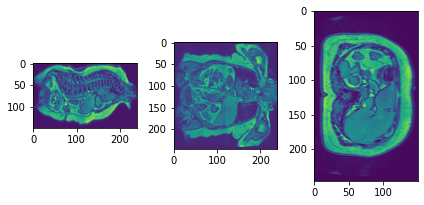

Affine:[[   2.            0.           -0.         -243.28070068]
 [   0.            2.           -0.         -152.59162903]
 [   0.            0.            3.         -678.91912842]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


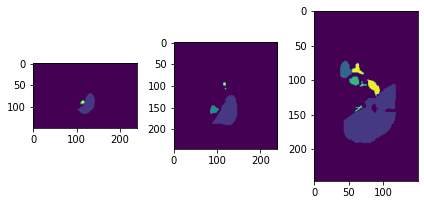

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
FINISHED.


In [19]:
print("STARTING KORA LABEL-MAPS.")
print('Reading Label Maps.....')
for vol in file_paths.keys():
    print(vol)
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    later = []
    print(file_paths[vol]['LABEL_PATHS'])
    if len(file_paths[vol]['LABEL_PATHS']) == 0:
        print(f"#################### ALERT:: NO LABELPATHS IN THE DICTIONARY FOR {vol} #########################")
        continue
    volume = nb.load(file_paths[vol]['N4_2']['OPP_CORRECTED'])
#     ref_vol = nb.load(file_paths[vol]['ONE_ORIG']['OPP'])
    img_ras_list = []
    for label_file_to_read in file_paths[vol]['LABEL_PATHS']:
        img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
        if img_ras is None:
            continue
        print(img_ras.shape, np.unique(img_ras.get_fdata()))
        img_ras = makeit_3d(img_ras)
        print('After 3d confirmed:', img_ras.shape,  np.unique(img_ras.get_fdata()))
#         UGLY HACK
        if labelname in ['PANCREAS']:
            later.append([img_ras, lidx, labelname])
        else:
            img_ras_list.append([img_ras, lidx, labelname])
    
    img_ras_list.extend(later)
    
    s_label = label_parts(img_ras_list)
    s_label = resample_to_output(s_label, TARGET_RESOLUTION, order=0, mode='constant', cval=0)
    if vol == 'KORA2460249':
        volume, s_label = kora_vol_label_fix(volume, s_label, True)
    else:
        volume, s_label = kora_vol_label_fix(volume, s_label)

    print('Viewing Stitched Images.....')
    volume_3_view_viewer(get_volume_data(volume))
    volume_3_view_viewer(get_volume_data(s_label))

    print('Saving Processed & Stitched Image.....')
    save_volume(volume, f'{processed_dir}/volume/{vol}')
    save_volume(s_label, f'{processed_dir}/label/{vol}')
    
print('FINISHED.')

In [20]:
# !pip install niwidgets

KORA2458366


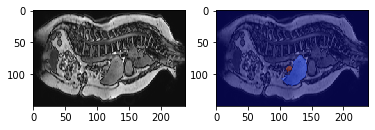

In [21]:
visualize_overlay(file_paths)

In [22]:
processed_dir = 'temp/KORA/processed_resized'
kora_labels = sorted(glob.glob(f'{processed_dir}/label_cropped/**'))
kora_volumes = sorted(glob.glob(f'{processed_dir}/volume_cropped/**'))

In [23]:
 
def visualize(volid, 
              vol_root=f'{processed_dir}/label_cropped', 
              label_root=f'{processed_dir}/volume_cropped',
             img_save_path = f'{processed_dir}/merged_imgs'):
    vol = nb.load(f'{vol_root}/{volid}.nii.gz')
    label = nb.load(f'{label_root}/{volid}.nii.gz')

    im = vol.get_fdata()
    x = im.shape[0]//2
    masked = label.get_fdata()
    plt.figure()
#     plt.subplot(1,2,1)
#     plt.imshow(im[x], 'gray', interpolation='none')
#     plt.subplot(1,2,2)
    plt.imshow(im[x], 'jet', interpolation='none')
    plt.imshow(masked[x], 'gray', interpolation='none', alpha=0.5)
    plt.savefig(f'{img_save_path}/{volid}.png',  dpi=250, quality=95)
    plt.show()


KORA2452879


FileNotFoundError: [Errno 2] No such file or directory: 'temp/KORA/processed_resized/merged_imgs/KORA2452879.png'

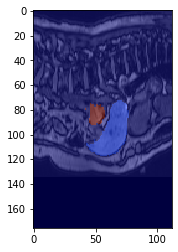

In [24]:
for p in kora_volumes:
    vol = p.split('/')[-1].split('.')[0]
    print(vol)
    visualize(vol)

In [ ]:
# file_dict= 
# {
#     VOL_ID: {
#         VOLUME_PATHS: {
#             OPP: [],
#             IN: [],
#             F: [],
#             W: []from nibabel.orientations import axcodes2ornt, ornt_transform, inv_ornt_aff, flip_axis
#         },
#         LABEL_PATHS: [],
#         N4_1: [
#             {
#                 SCALED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled.nii.gz',
#                 IN_BIAS: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_bias_field.nii.gz',
#                 IN_CORRECTED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_corrected.nii.gz',
#                 OPP_CORRECTED: '',
#                 MIN: u_min,
#                 MAX: u_max
#             },
#             {},
#             {}
#         ],from nibabel.orientations import axcodes2ornt, ornt_transform, inv_ornt_aff, flip_axis
#         ONE     : {
#             OPP: '',
#             IN: '',
#             F: '',
#             W: '',
#         },
#         N4_2: {
#             SCALED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled.nii.gz',
#             IN_BIAS: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_bias_field.nii.gz',
#             IN_CORRECTED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_corrected.nii.gz',
#             OPP_CORRECTED: '',
#             MIN: u_min,
#             MAX: u_max
#         },
        
#     }
# }

In [ ]:
a = {'a':1, 'b':2, 'c':3}

In [ ]:
len(a)
